In [2]:
import pandas as pd
pd.read_csv('data/globalterrorismdb_0617dist.csv', header=0, encoding='ISO-8859-1').shape

/Users/Paul/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(170350, 135)

# Machine Learning for Counterterrorism
**Authors:** Akhil Jalan, Yakub Akhmerov, Paul Kim

# Abstract

Terrorism, defined broadly as "the use of intentionally indiscriminate violence as a means to create terror, or fear, to achieve a political, religious or ideological aim" (Wikipedia), is a defining global challenge in the 21st century. In order to assist the fight against terrorism, the University of Maryland's Department of Homeland Security Center of Excellence compiled an extensive and rich database of international terrorist attacks from 1970 to 2016, to be used for analysis and data science purposes. 

In order to inform counterterrorism strategy, we sought to answer a critical question: **what factors are most influential in determining whether a terrorist attack succeeds or fails?** Armed with this information, counterterrorist organizations would be better able to prioritize their foci for further research and training. 

# Introduction

## Preprocessing

The raw data came in the form of two large csv files, with a total of 170350 entries spanning 135 variables with information on the date, attack type, location, tactics, perpetrating groups, targets, and outcomes. 

In order to preprocess the data, we made a Python file with convenient preprocessing functions that could be run at the start of each analysis notebook. These preprocessing functions loaded raw csv data into a Pandas dataframe, dropped unused columns or columns with a large number of NaNs ("Not a Number" values which represent missing data), and created one-hot-encoded dummy variables from the important categorical features. Note that since we used a one-hot encoding, our vectors are *sparse*: most of their entries are 0. 

This workflow was not the only possible one. We could have made a separate notebook that, when executed, outputted the cleaned data and saved it to file, which could then be loaded in subsequent notebooks. However, because all three of us had different workflows and the overall structure of the project was not sequential, we felt this would lead to unnecessary complications. The models in our analyses each used slightly different subsets of the data, and as such it makes more sense to preprocess the data separately for each model. 

## Analysis

Roughly, our analysis falls into one of two categories **exploration** and **prediction**. In exploratory analysis, we sought to understand the underlying patterns and trends in the data via various shallow computations and visualizations. In predictive analysis, we built statistical models to predict whether a given terrorist 

# Exploration

In this section, we explain some of the most informative results of our exploratory analysis. While these analyses did not model sucess/failure rates of terrorist attacks, they were essential to informing our choice of models and variables. Moreover, in a database with over 100 variables, it was necessary to make sense of what information was meaningful and what could be left out. 

## Basic Trends

TODO

## Geographic Visualizations 

TODO include Yakub maps

## Affinity Maps

We use the term **affinity map** to refer to a heatmap which displays the 'distance' between different categories in a trait of interest. For example, we might want to understand the level of similarity between terrorist attacks which use chemical weapons and those which use explosives. 

How should one measure this similarity? Given that we have used a one-hot encoding of the data, each terrorist attack is represented as a vector in a high-dimensional space of the form $\mathbb{R}^{n}$.In particular, all of the values were either $0$ or $1$. Given the vector representation, a natural way to measure distance is the Euclidean distance on $\mathbb{R}^{n}$, or the $\ell_2$ distance. This distance corresponds to the physical distance between points in space. Formally, if $\vec{x}, \vec{y} \in \mathbb{R}^{n}$, then $$d(\vec{x}, \vec{y}) = \| \vec{x} - \vec{y} \|_2$$. It is important to note the following:

1. For computational efficiency, we compute the distance of the means of the sub-groups rather than the average of pair-wise distances between each subgroup. Given that our dataset has over 170,000 attacks, the latter would be far too expensive to be feasible. 

2. Despite the fact that we are using a heatmap, we are interested in *lower values*, not higher ones. This is because high values indicate a larger distances than smaller ones. However, understanding which categories are the "furthest apart" is also of interest. 

We display some of these affinity maps below. See ```counter_terrorism_nb2``` for details.

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.figure as fig
%matplotlib inline

def display_image(filepath): 
    '''
    Displays an image from file. 
    filepath: A string corresponding to the filepath of the image. 
    '''
    assert 'figures/' in filepath, 'Wrong filepath'
    assert '.png' in filepath, 'Filename does not contain .png'
    
    plt.rcParams['figure.dpi']= 400
    img = mpimg.imread(filepath)
    plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

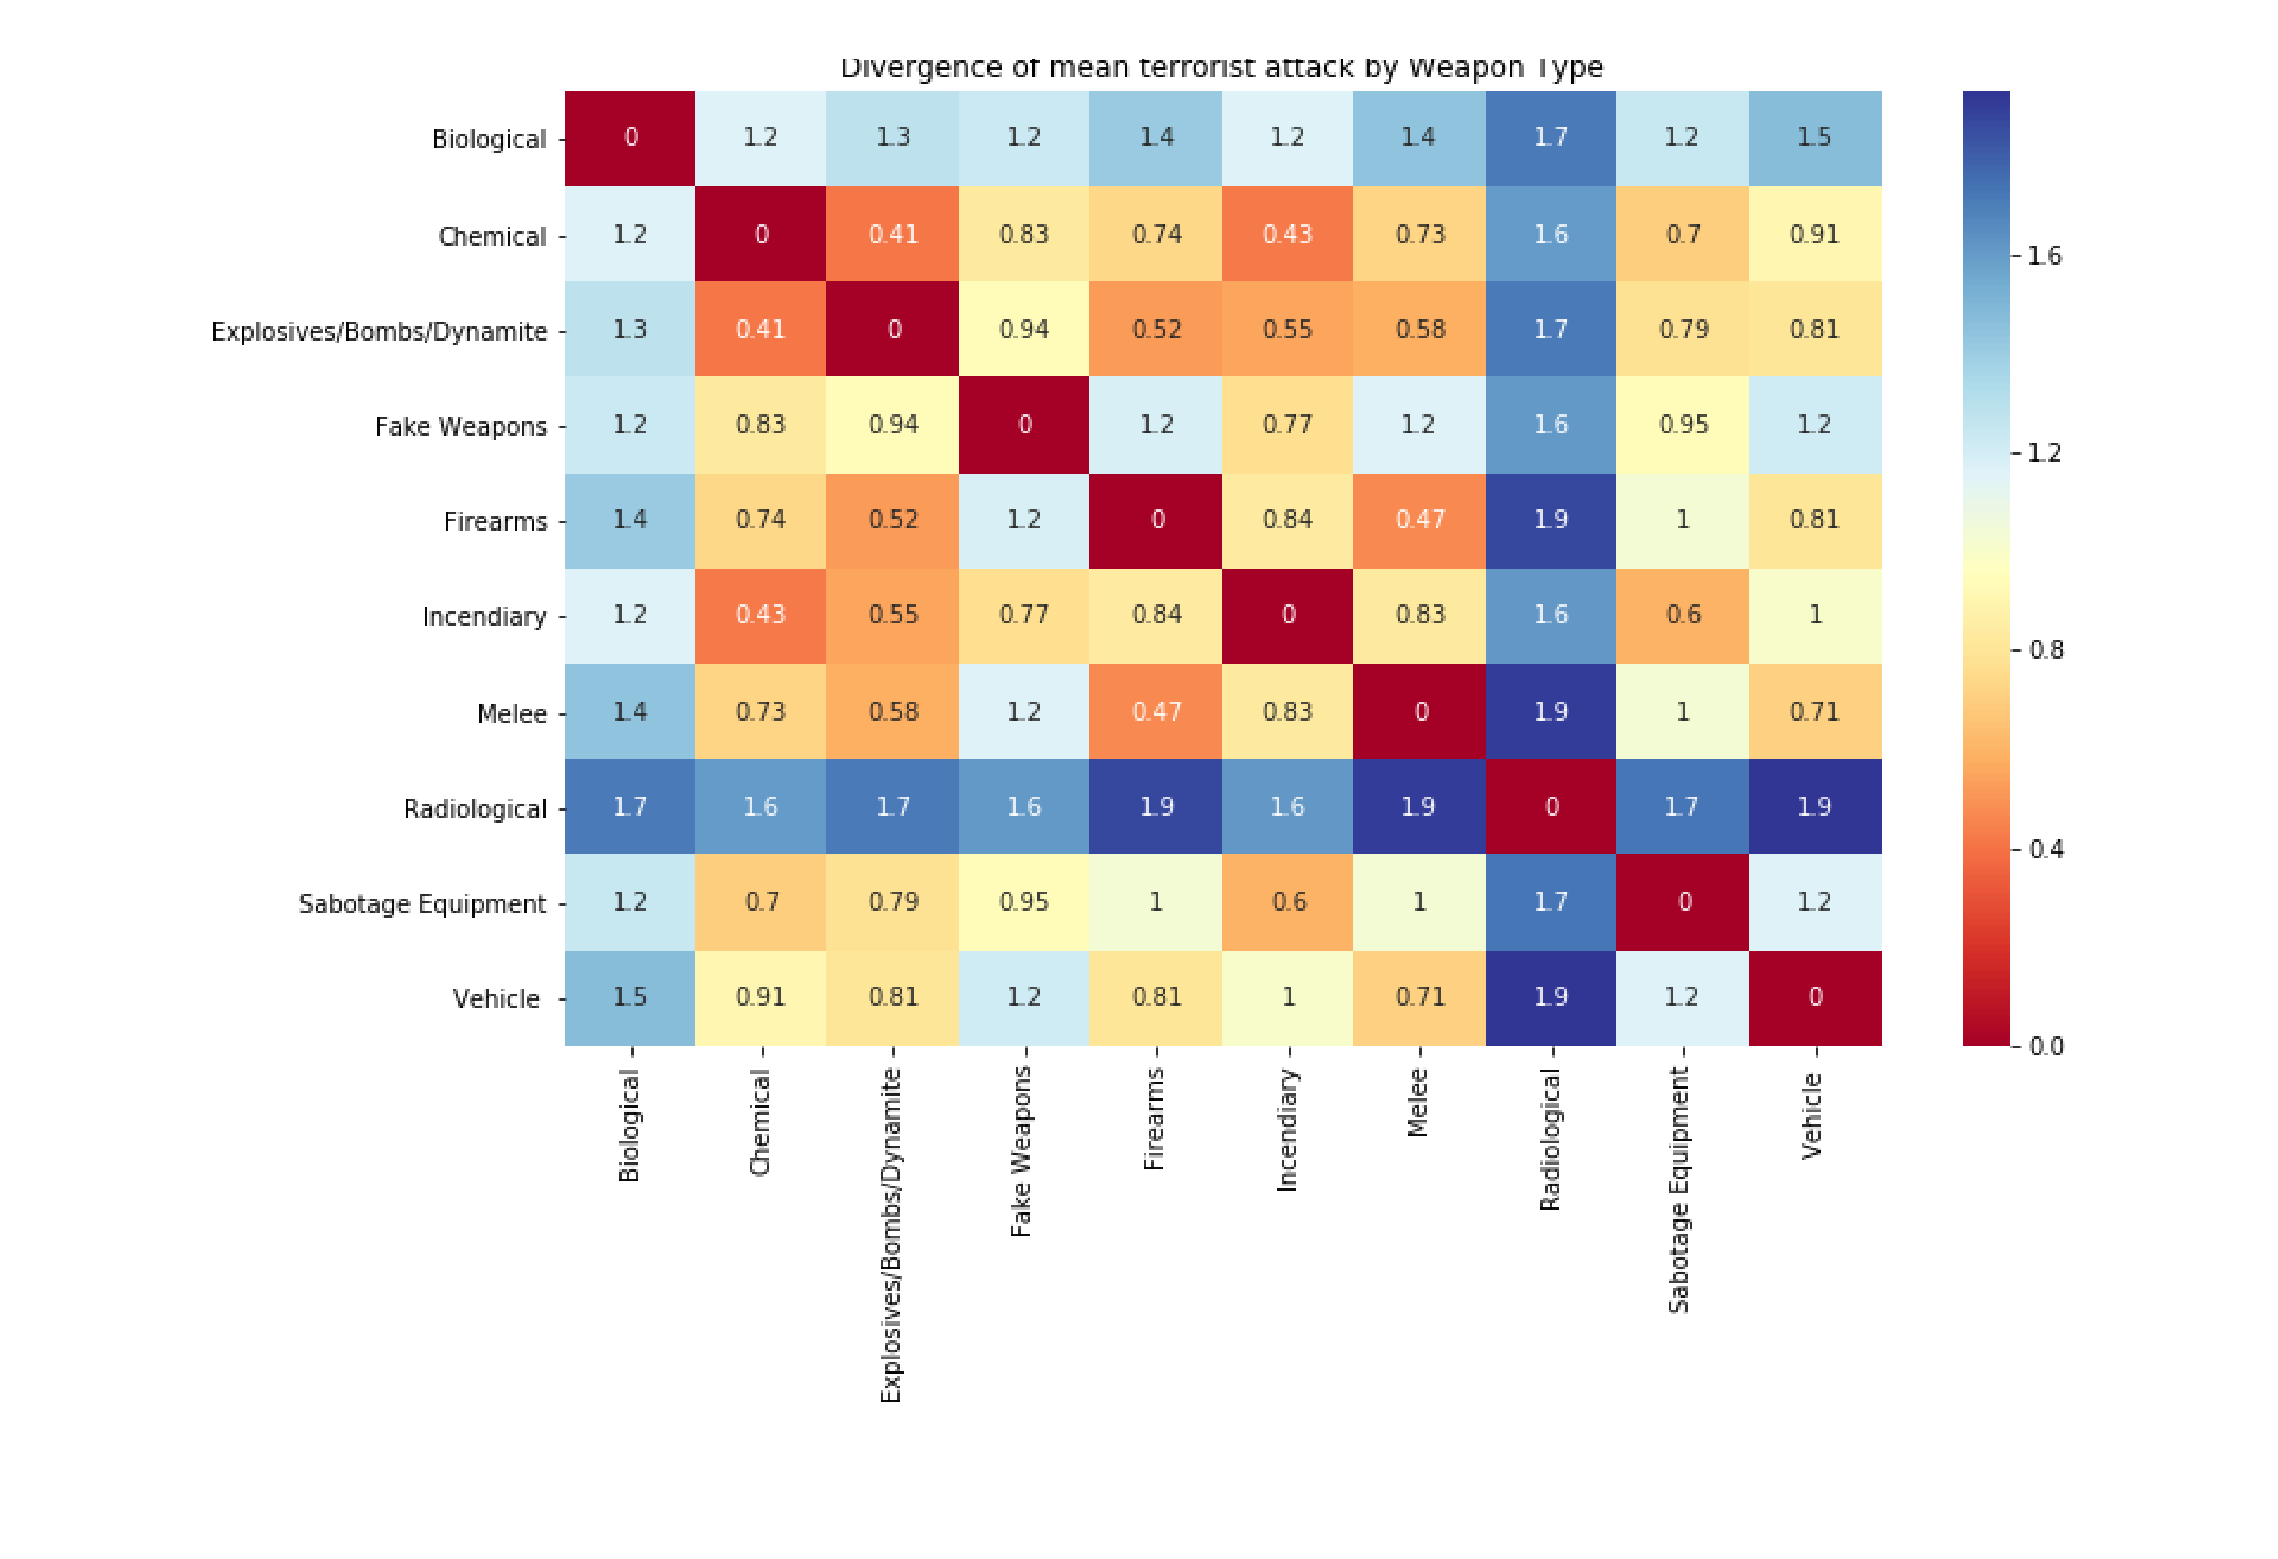

In [33]:
display_image('figures/all_weaptype_heatmap.png')

Above is an affinity map of terrorist attacks by weapon type. Evidently, some attack types are quite similar to one another, while others are relatively diffeerent. 

Like weapon types, target types display substantial variation. Notably, abortion-related attacks are substantially different from every other type of attack in the database.

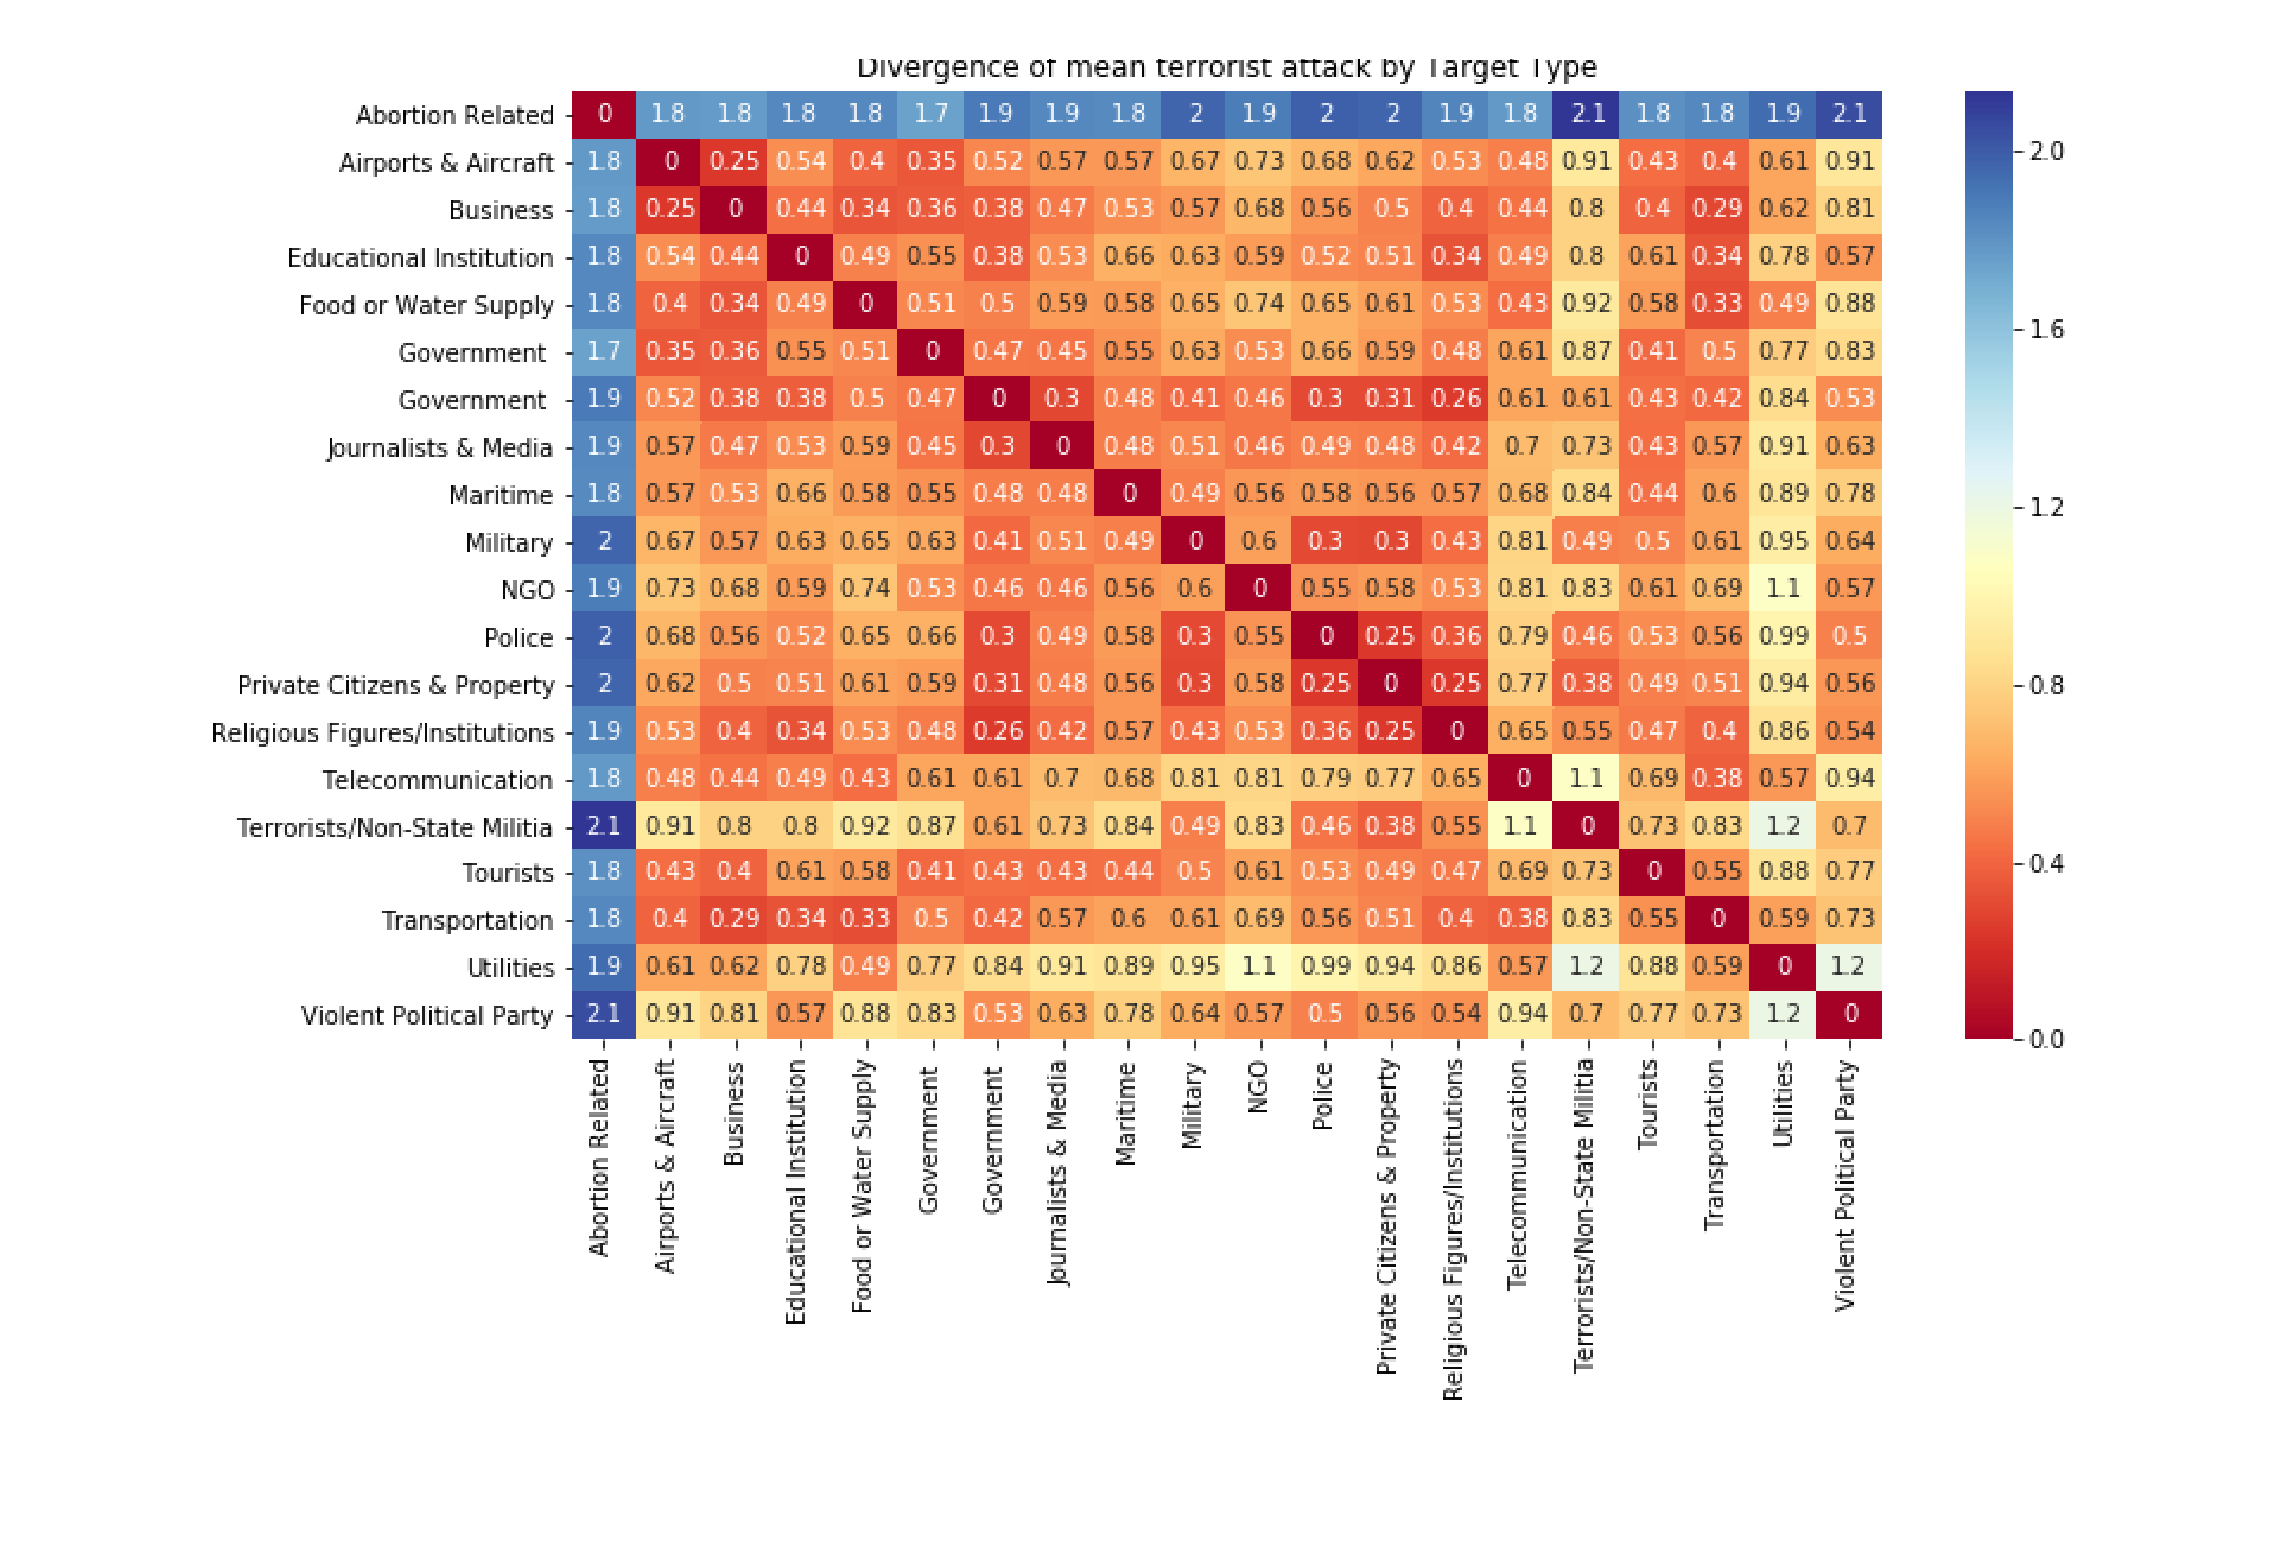

In [35]:
display_image('figures/all_targtype_heatmap.png')

For ease of interpretation, we display the affinity map above with only the 30% closest cells.

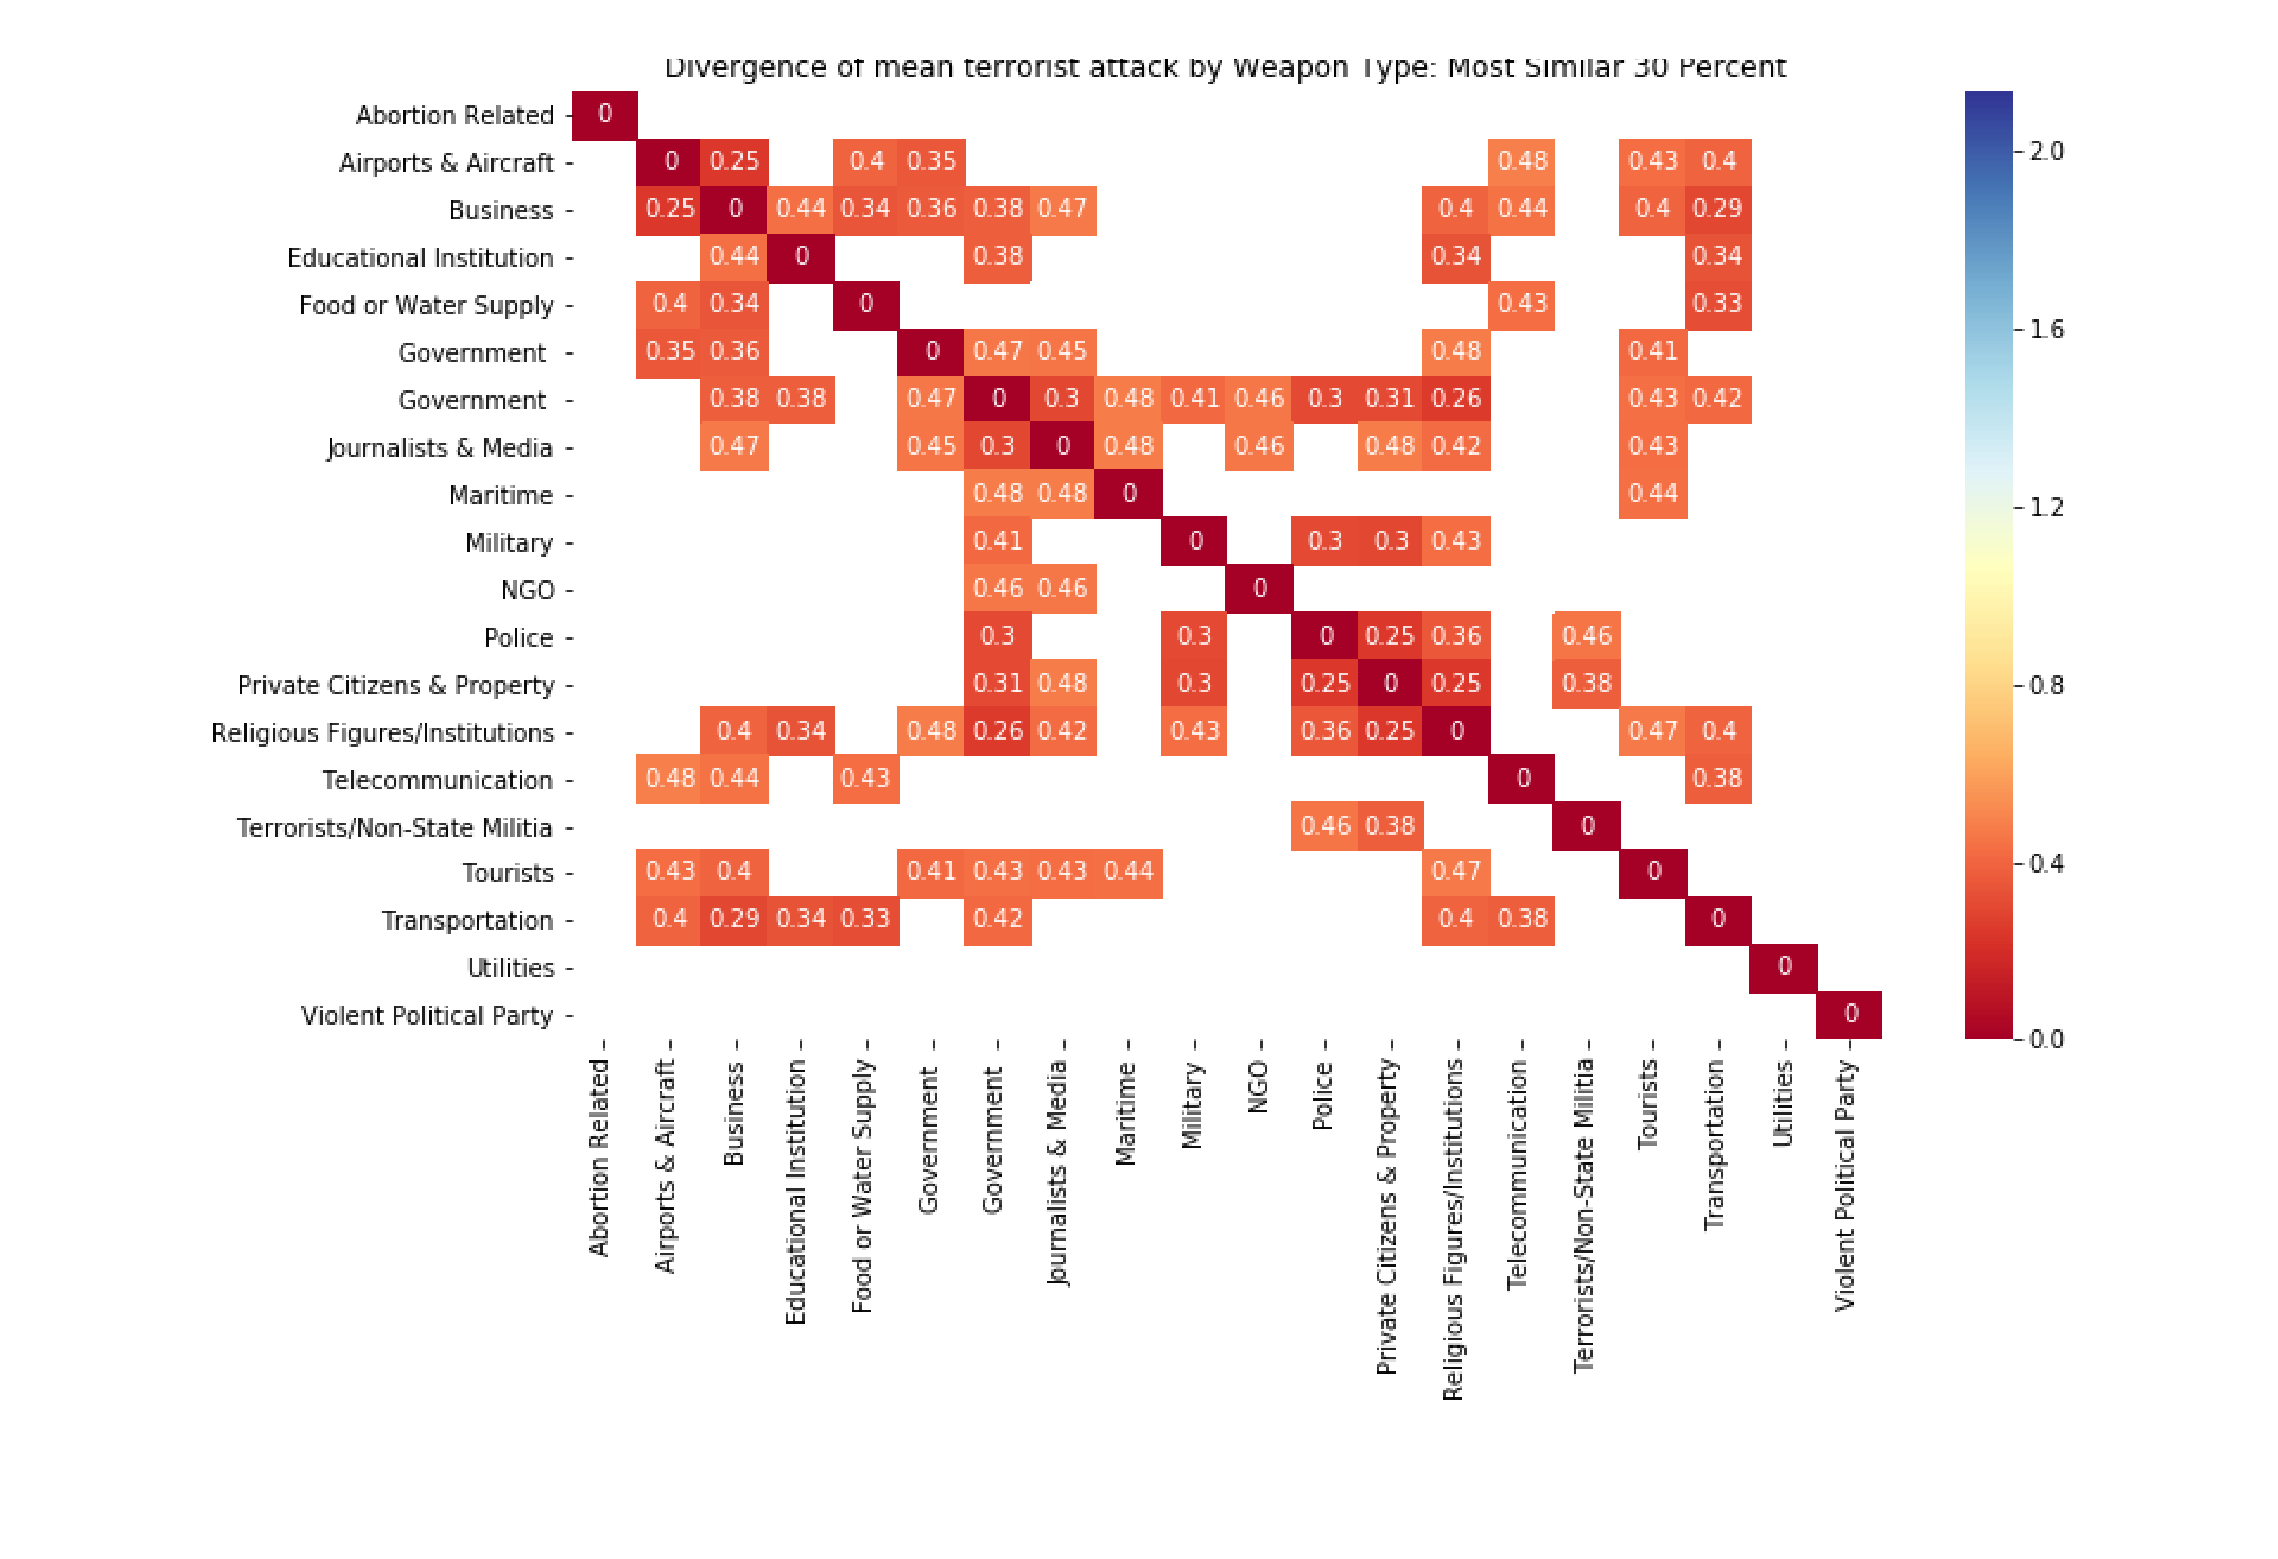

In [37]:
display_image('figures/top30_targtype_heatmap.png')

Finally, we display the affinity map of groups with over 500 recorded attacks in the database. With a few exceptions, most groups are not very similar to one another. 

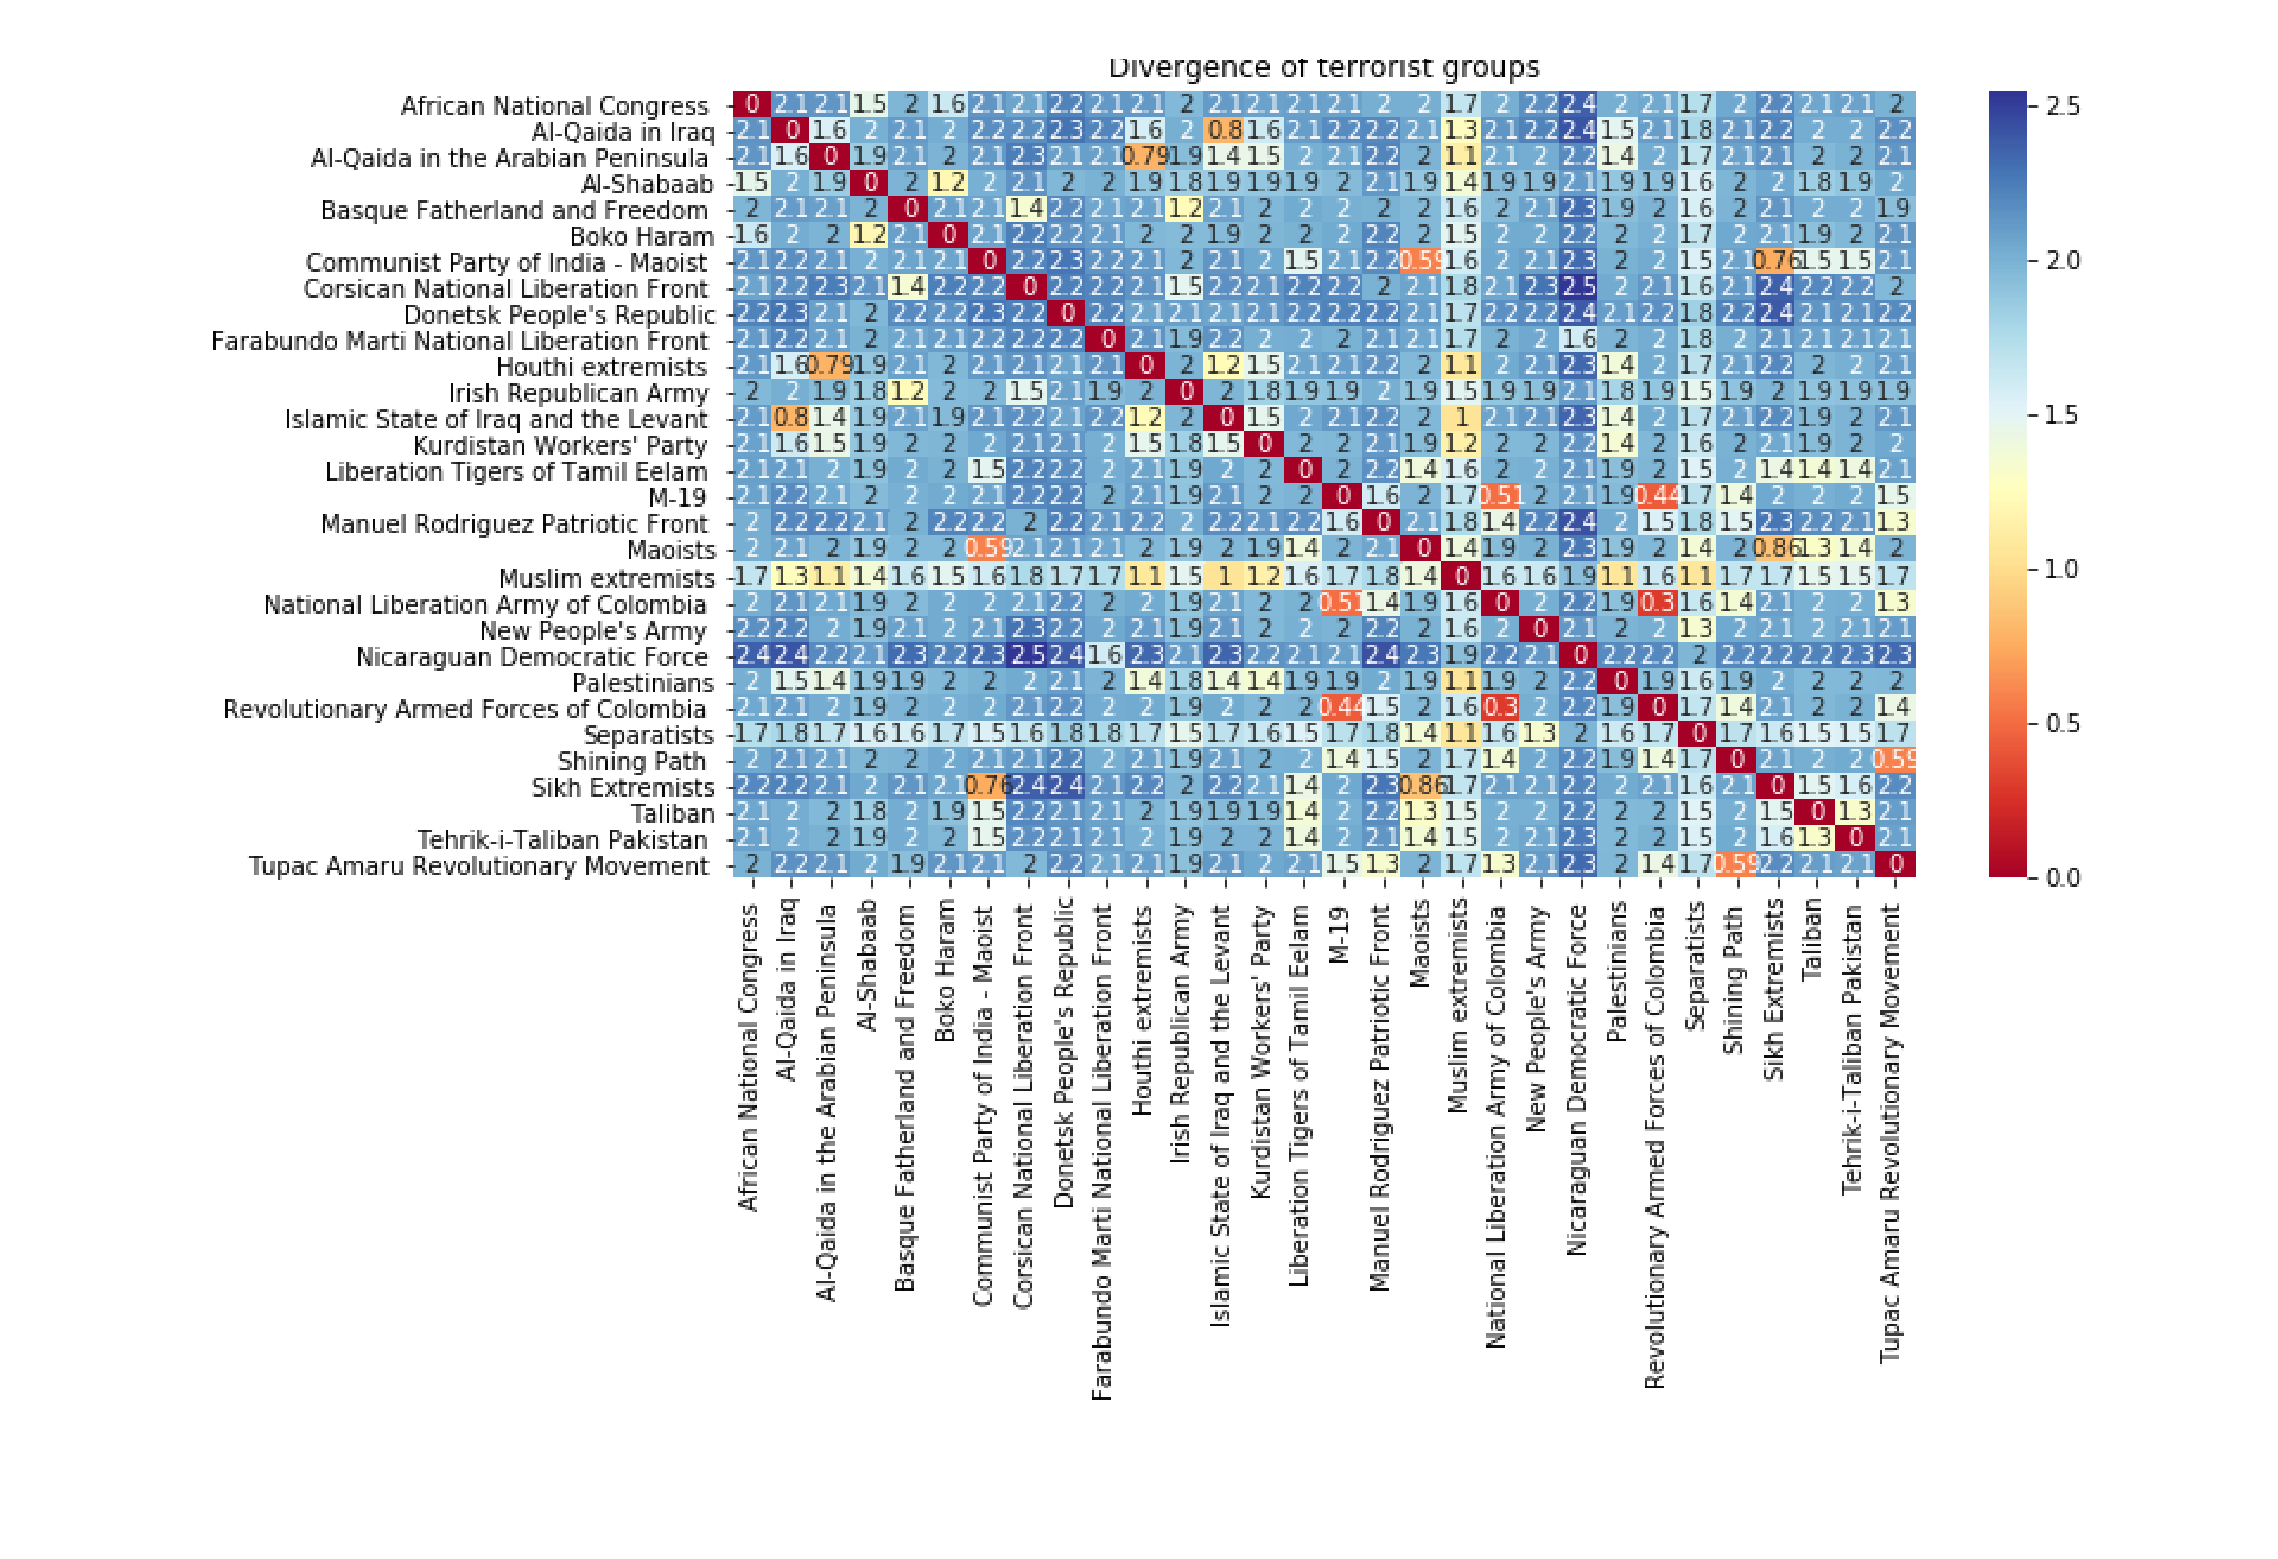

In [38]:
display_image('figures/all_groups_heatmap.png')

Here is the same figure, but with only the 30% of cells with the smallest distances.

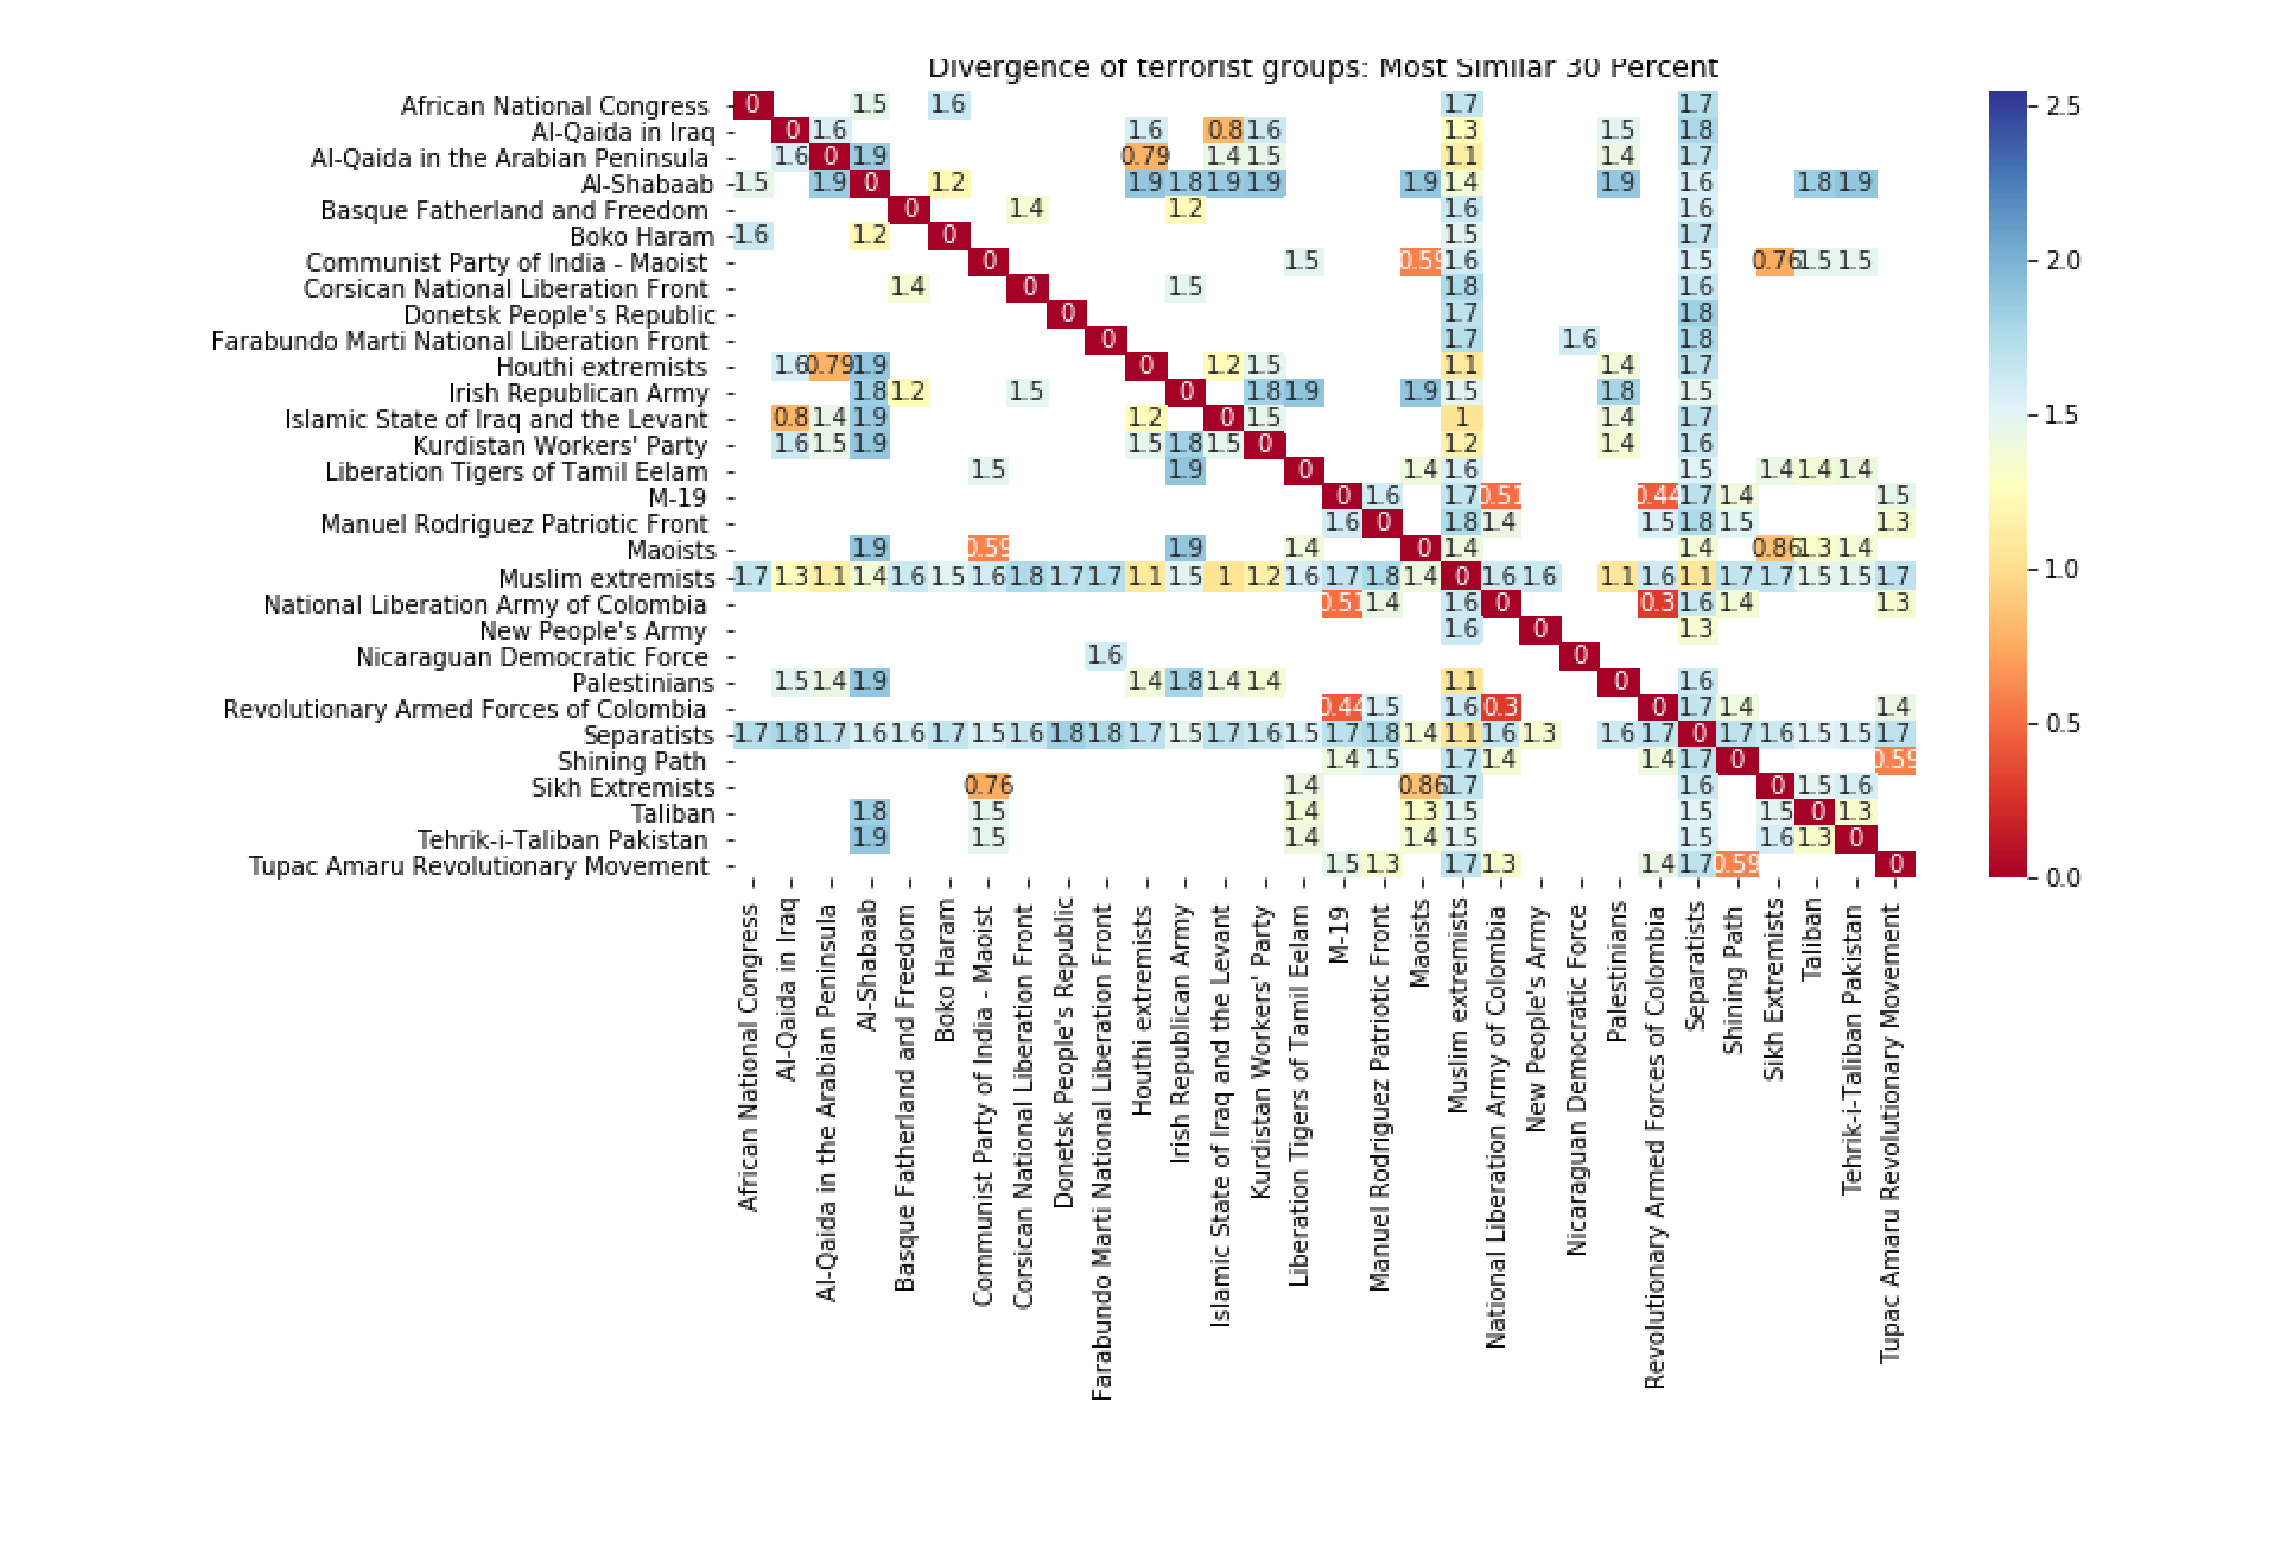

In [32]:
display_image('figures/top30_groups_heatmap.png')

Notably, there are strong similarities for groups based in the same country. FARC and M-19, both Colombian terrorist groups, have a very high level of similarity. So do Shining Path and Tupac Amaru Reviolutionary Movement, both from Peru. This indicates that country of origin is an important feature for future models.

# Prediction

Our database of attacks contained several success-related metrics for each attack, such as the number of people killed, number wounded, and number of Americans killed. We chose to concentrate on the categorical variable **success**, which for each attack was either 1 (true) or 0 (false). Whether an attack was deemed successful depended on the situational details, and was different for each type of attack. The database [codebook](http://www.start-dev.umd.edu/gtd/downloads/Codebook.pdf) explains that: 

> "Success of a terrorist strike is defined according to the tangible effects of the attack. Success is not judged in terms of the larger goals of the perpetrators. For example, a bomb that exploded in a building would be counted as a success even if it did not succeed in bringing the building down or inducing government repression.  
>The definition of a successful attack depends on the type of attack. Essentially, **the key question is whether or not the attack type took place.** If a case has multiple attack types, it is successful if any of the attack types are successful, with the exception of assassinations, which are only successful if the intended target is killed."

## Formalization 

Recall that in the pre-processing of the data, categorical information about each attack was converted to a vector representation using a one-hot encoding. For example, suppose that the variable "perpretator" has two possibilities: "Fernando" and "Eli." Then a one-hot encoding might represent "Fernando" as $\begin{bmatrix} 1 \\ 0\end{bmatrix}$ and "Eli" as $\begin{bmatrix} 0 \\ 1\end{bmatrix}$. 

Given an attack with several categorical variables, its vectorized representation is thus a vector $\vec{v} \in \mathbb{R}^{n}$ which is really a "stack" of smaller one-hot vectors corresponding to each feature. If we use $m$ categorial features from each attack, each vector $\vec{v}$ will have precisely $m$ entries whose value is $1$, and all others $0$. 

Not all of the features were categorical. Numerical features, such as "number of people killed" or "year" might have been converted into a one-hot encoding, or simply appended to the one-hot vector. See the analysis notebooks (TODO LINK HERE) for more detail. 

Suppose then that we have $n$ vectors $\vec{x_{1}}, ..., \vec{x_{n}}$, each corresponding to an attack. Each attack vector $\vec{x_i}$ has a label $y_{i} \in \{0, 1 \}$ which is $1$ if the attack was successful, and $0$ if the attack was unsuccessful. 

Given vectorized data and class labels, we can split the data into a training and test set and perform cross-validation. The goal of any model is to learn a model from the training data, and then predict (with as high a degree of accuracy as possible) the labels of the test data.

## Random Forest

